# Calculate Capacitance from WHAM

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import warnings
font = {'size'   : 16}
plt.rc('font', **font)

Load and plot the unbiased probability $P(Q|0\,\mathrm{V})$ obtained from whampy employing a linear bias potential.

Text(0, 0.5, '$F(Q|0\\,\\mathrm{V})$ / eV')

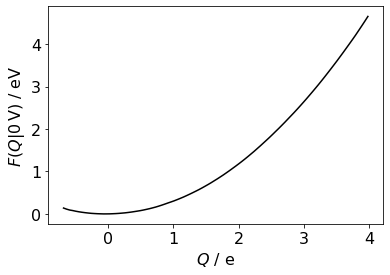

In [2]:
k_B = 8.617333262e-5 # in eV/K 
T = 298.0 # in K
kT = k_B*T
beta = 1./kT

Qbin, pmf, err = np.loadtxt('wham_output.pmf',unpack=True)

plt.plot(Qbin, pmf, 'k-')
plt.fill_between(Qbin, pmf-err, pmf+err, facecolor='grey',alpha=0.2)
plt.xlabel("$Q$ / e")
plt.ylabel("$F(Q|0\,\mathrm{V})$ / eV")

The free energy at a given potential is obtained by subtracting the bias from the PMF at 0V since $P(Q|\Delta\Psi)$ is proportional to $P(Q|0\,\mathrm{V}) \cdot \exp(-\beta Q \Delta \Psi)$ (see Merlet et al., JPCC, 2014) and is basically just a shift. The results from that in the figure below show that the greater the potential difference, the greater the probability of a higher electrode charge, i.e., $\langle Q\rangle$ is approximately 3.2$\,$e at 2$\,$V while it is almost zero at zero potential.

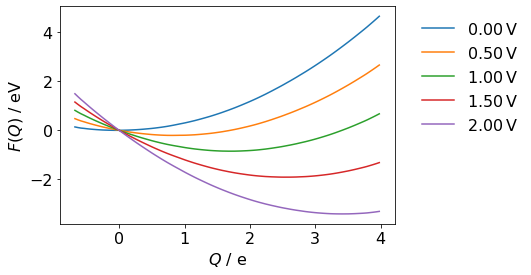

In [3]:
warnings.filterwarnings('ignore')
psi = np.linspace(0.,2.,5)
for i in range(len(psi)):
    # free energy formulation
    plt.plot(Qbin,pmf-Qbin*psi[i], label='%.2f$\,$V' % psi[i])
plt.xlabel('$Q$ / e')
plt.ylabel('$F(Q)$ / eV')
plt.legend(frameon=False, bbox_to_anchor=(1.04,1), loc="upper left")

## Estimate differential capacitance
The differential capacitance can be calculated from the variance of the electrode charge (see Limmer et al., PRL, 2013) and is scaled with the surface area. Data of the total charge on the electrodes stems from a simulation containing flat graphitic electrodes and 1.5M \[BMI\]\[PF<sub>6</sub>\] in acetonitrile.

Text(0, 0.5, '$C_\\mathrm{diff}$ / $\\mathrm{\\mu}$F$\\cdot$cm$^{-2}$')

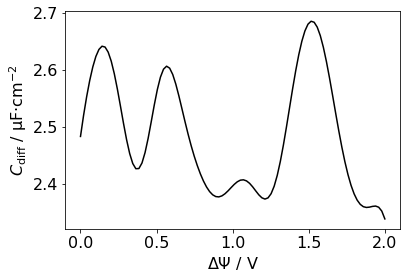

In [4]:
S = 11.0768e-18 * 1e4 # nm->cm²
qe = 1.60218e-19 # C
eVinJ = 1.60218e-19

psi = np.linspace(0.,2.,100)
meanQ = np.zeros(len(psi))
varQ = np.zeros(len(psi))
weights = np.exp(-beta*pmf) # Boltzmann weights
for i in range(len(psi)):
    shift = np.exp(beta*Qbin*psi[i])
    p = weights*shift 
    Z = sum(weights*shift) 
    meanQ[i] = sum(p*Qbin)/Z
    varQ[i] = sum(p*(Qbin-meanQ[i])**2)/Z
Cdiff = beta * varQ * qe / S * 1e6 # muF / cm²

plt.plot(psi,Cdiff,'k')
plt.xlabel(r'$\Delta\Psi$ / V')
plt.ylabel(r'$C_\mathrm{diff}$ / $\mathrm{\mu}$F$\cdot$cm$^{-2}$')

### Estimate confidence intervals of capacitance from bootstrapping the PMF
95%-confidence of the probability is estimated by sampling with replacement and storing each time the bootstrapped PMF. Each bootstrapped PMF is then shifted again with the potential. For each bootstrapped (and shifted) PMF we calculate $C_\mathrm{diff}$ and its 95% confidence interval at any given applied potential.

In [5]:
bootstraps = np.loadtxt("bootstraps.pmf")

In [6]:
Cbootstraps = np.array([]).reshape(-1,len(psi))
for pmfs in bootstraps:
    meanQ = np.zeros(len(psi))
    varQ = np.zeros(len(psi))
    weights = np.exp(-beta*pmfs) # Boltzmann weights
    for i in range(len(psi)):
        shift = np.exp(beta*Qbin*psi[i])
        p = weights*shift 
        p /= sum(weights*shift) 
        meanQ[i] = sum(p*Qbin)
        varQ[i] = sum(p*(Qbin-meanQ[i])**2)
    Cbootstraps = np.vstack([Cbootstraps, beta * varQ * qe / S * 1e6]) # muF / cm²

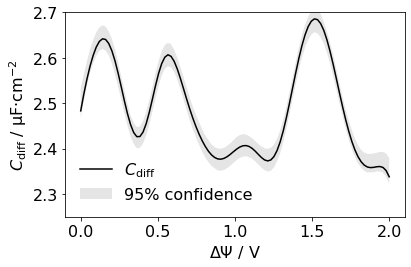

In [7]:
lower_conf = np.percentile(Cbootstraps, 0.5, axis=0)
upper_conf = np.percentile(Cbootstraps, 99.5, axis=0)
plt.plot(psi, Cdiff, 'k-', label='$C_\mathrm{diff}$')
plt.fill_between(psi, lower_conf, upper_conf, facecolor='grey',alpha=0.2, label='95% confidence')
plt.xlabel('$\Delta\Psi$ / V')
plt.ylabel(r'$C_\mathrm{diff}$ / $\mathrm{\mu}$F$\cdot$cm$^{-2}$')
plt.ylim([2.25,2.7])
plt.legend(frameon=False, loc=3)
plt.tight_layout()

For each bootstrapped (and shifted) PMF we calculate $C_\mathrm{diff}$ to obtain the standard deviation of the differential capacitance at any given applied potential.

In [8]:
Cfake = np.zeros(len(psi))
Cfakesq = np.zeros(len(psi))
for pmfs in bootstraps:
    meanQ = np.zeros(len(psi))
    varQ = np.zeros(len(psi))
    weights = np.exp(-beta*pmfs) # Boltzmann weights
    for i in range(len(psi)):
        shift = np.exp(beta*Qbin*psi[i])
        p = weights*shift 
        p /= sum(weights*shift) 
        meanQ[i] = sum(p*Qbin)
        varQ[i] = sum(p*(Qbin-meanQ[i])**2)
    Ctmp = beta * varQ * qe / S * 1e6 # muF / cm²
   
    Cfake += Ctmp
    Cfakesq += Ctmp**2
    
Cfake /= len(bootstraps)
Cfakesq /= len(bootstraps)
Cstd = np.sqrt(Cfakesq - Cfake**2)
print("max. std of Cdiff %.6f muF / cm²" % Cstd.max())

max. std of Cdiff 0.012832 muF / cm²


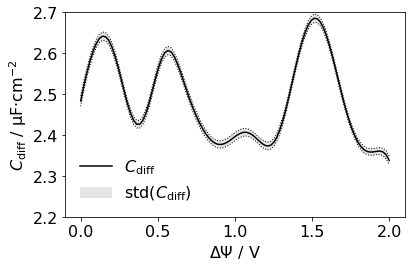

In [9]:
plt.plot(psi, Cdiff, 'k-', label='$C_\mathrm{diff}$')
plt.plot(psi, Cdiff-Cstd, 'k:', lw=1)
plt.plot(psi, Cdiff+Cstd, 'k:', lw=1)
plt.fill_between(psi, Cdiff-Cstd, Cdiff+Cstd, facecolor='grey',alpha=0.2, label='$\mathrm{std}(C_\mathrm{diff})$')
#plt.plot(psi, Cfake, 'bx', label=r'bootstrapped $\langle C_\mathrm{diff}\rangle$')
plt.xlabel('$\Delta\Psi$ / V')
plt.ylabel(r'$C_\mathrm{diff}$ / $\mathrm{\mu}$F$\cdot$cm$^{-2}$')
plt.legend(frameon=False,loc=3)
plt.ylim([2.2,2.7])
plt.tight_layout()

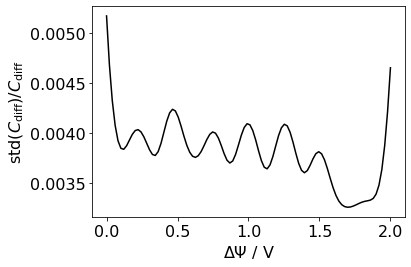

In [10]:
plt.plot(psi, Cstd/Cdiff, 'k-')
plt.xlabel('$\Delta\Psi$ / V')
plt.ylabel('$\mathrm{std}(C_\mathrm{diff})/C_\mathrm{diff}$')
plt.tight_layout()